### $d=2$

$$\Omega = [0, L_x]\times[0,L_y]$$
$$\textbf{a}=(a\cos\theta,a\sin\theta)$$

In [ ]:
import numpy as np
from lucifex.mesh import rectangle_mesh
from lucifex.fem import Function, Constant
from lucifex.solver import BoundaryValueProblem, bvp, BoundaryConditions
from lucifex.viz import plot_colormap
from lucifex.io import write, get_ipynb_file_name
from lucifex.pde.advection_diffusion_steady import advection_diffusion_steady
from lucifex.pde.supg import peclet


def create_solver(
    supg: str | None,
    Lx: float,
    Ly: float,
    Nx: int,
    Ny: int,
    u_inflow: float,
    y_inflow: float,
    d: float, 
    a: float,
    theta: float,
) -> BoundaryValueProblem:
    mesh = rectangle_mesh(Lx, Ly, Nx, Ny)
    theta_rad = theta * np.pi / 180
    ax = a * np.cos(theta_rad)
    ay = a * np.sin(theta_rad)
    a = Constant(mesh, (ax, ay), name='a')
    d = Constant(mesh, d, name='d')
    u = Function((mesh, 'P', 1), name='u')
    bcs = BoundaryConditions(
        ('dirichlet', lambda x: x[1], 0.0),
        ('dirichlet', lambda x: np.isclose(x[0], 0) & (x[1] < y_inflow), 0.0),
        ('dirichlet', lambda x: np.isclose(x[0], 0) & (x[1] > y_inflow), u_inflow),
        ('neumann', lambda x: x[0] - Lx, 0.0),
        ('neumann', lambda x: x[1] - Ly, 0.0),
    )
    u_solver = bvp(advection_diffusion_steady, bcs=bcs)(
        u, a, d, supg=supg,
    )
    return u_solver


Lx = 1.0
Ly = 1.0
Nx = 20
Ny = 20
u_inflow = 1.0
y_inflow = 0.2
d = 10e-4
a = 1.0
theta = 30.0

hx = Lx / Nx
hy = Ly / Ny
Pe_x = peclet(hx, a, d)
Pe_y = peclet(hy, a, d)

supg_types = (None, 'coth', 'upwind')
results: dict[str | None, Function] = {}
for supg in supg_types:
    u_solver = create_solver(supg, Lx, Ly, Nx, Ny, u_inflow, y_inflow, d, a, theta)
    u_solver.solve()
    results[supg] = u_solver.solution

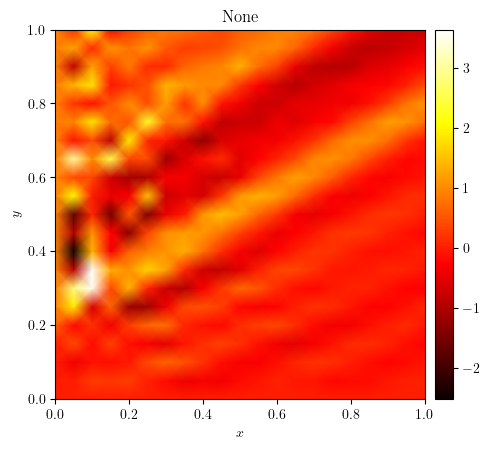

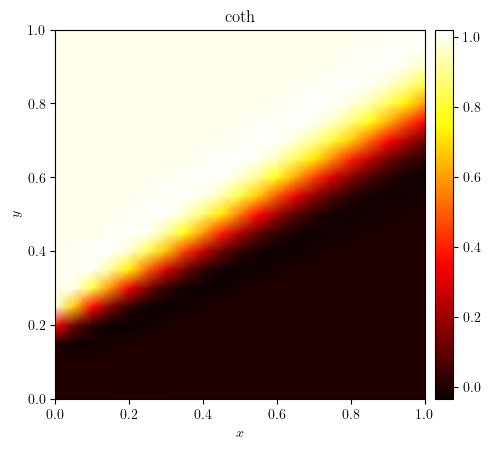

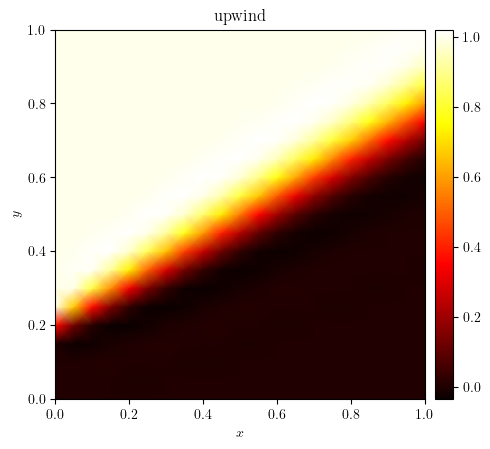

: 

In [ ]:
for supg, u in results.items():
    plot_colormap(u, title=f'{supg}')